In [6]:
# The code is developed for the paper "Customer Segmentation Applied On RFM-ID Model"

# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler
from scipy.special import logsumexp
from sklearn.metrics import davies_bouldin_score



# Loading Data 

~ Data Description ~

InvoiceNo(Nominal): A 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation. 

StockCode(Nominal): Product (item) code. A 5-digit integral number uniquely assigned to each distinct product. 

Description(String):  Product (item) name. 

Quantity(Numeric): The quantities of each product (item) per transaction.

InvoiceDate(Numeric): Invoice date and time. The day and time when a transaction was generated. 

UnitPrice(Numeric): Product price per unit in sterling (Â£). 

CustomerID(Nominal): A 5-digit integral number uniquely assigned to each customer. 

Country(Nominal): The name of the country where a customer resides.



In [3]:
df_dict = pd.read_excel('./data/online_retail.xlsx', sheet_name=None) # contains two excel sheets

In [7]:
df_1 = df_dict['Year 2009-2010']
df_2 = df_dict['Year 2010-2011']

df_c = pd.concat([df_1, df_2]) 

In [8]:
print(f"Number of records: {df_c.shape[0]}")

Number of records: 1067371


In [9]:
df_c.head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


In [10]:
df_c.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [11]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 73.3+ MB


# Pre-processing

## Removing Null values

In [12]:
null_values_percentage = round(100*(df_c.isnull().sum())/len(df_c), 2)

In [13]:
null_values_percentage

Invoice         0.00
StockCode       0.00
Description     0.41
Quantity        0.00
InvoiceDate     0.00
Price           0.00
Customer ID    22.77
Country         0.00
dtype: float64

In [14]:
# As we see custoemr ID has around 22% percent of null values. We are will drop these columns.

In [15]:
df_proc = df_c.dropna() # pre-processed data frame (data_proc)

In [16]:
df_proc.describe()

,Quantity,Price,Customer ID
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504
std,188.976099,70.241388,1697.464450
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,5.000000,1.950000,15255.000000
75%,12.000000,3.750000,16797.000000
max,80995.000000,38970.000000,18287.000000


## Removing Negative values

In [17]:
df_proc = df_proc[~df_proc["Invoice"].str.contains("C", na = False)]

## Removing Outliers

In [18]:
df_proc[["Quantity", "Price"]]

,Quantity,Price
0,12,6.95
1,12,6.75
2,12,6.75
3,48,2.10
4,24,1.25
...,...,...
541905,6,2.10
541906,4,4.15
541907,4,4.15
541908,3,4.95


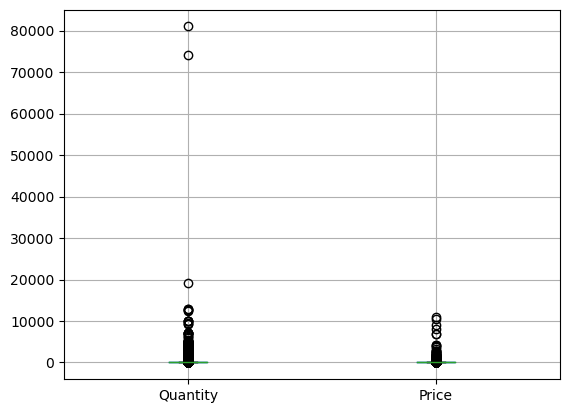

In [19]:
df_proc[["Quantity", "Price"]].boxplot()
plt.show() # Why this line made it to work?

In [20]:
# As we see, Quantity and Price have outliers. So, we will remove them.

In [21]:
# Removing outliers from the Quantity attribute
Q1 = df_proc.Quantity.quantile(0.25)
Q3 = df_proc.Quantity.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df_proc = df_proc[(df_proc.Quantity>lower_limit)&(df_proc.Quantity<upper_limit)]


In [22]:
# Removing outliers from the Price attribute
Q1 = df_proc.Price.quantile(0.25)
Q3 = df_proc.Price.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

df_proc = df_proc[(df_proc.Price>lower_limit)&(df_proc.Price<upper_limit)]


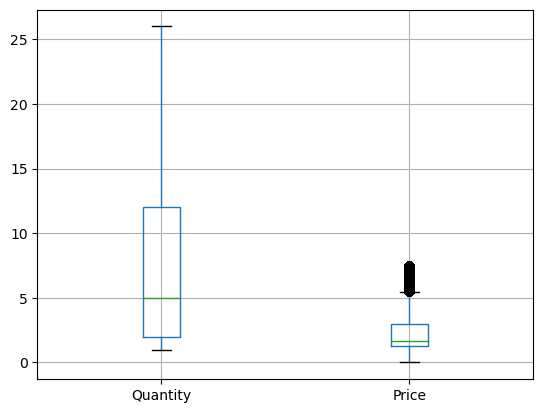

In [23]:
df_proc[["Quantity", "Price"]].boxplot()
plt.show() # Why this line made it to work?

In [24]:
df_proc.describe()

,Quantity,Price,Customer ID
count,686023.000000,686023.000000,686023.000000
mean,7.299531,2.269788,15362.101306
std,6.692578,1.599637,1694.422894
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,14019.000000
50%,5.000000,1.690000,15311.000000
75%,12.000000,2.950000,16841.000000
max,26.000000,7.490000,18287.000000


# RFMVD Score

R(Recenecy): How recently did the customer purchase?

F(Frequency): How often do they purchase?

M(Monetary): How much do they spend?

V(Variety): How many products sold by each customer?

D(Duration): How much time between each two transactions?

In [25]:
# Numbber of descriptions per product for each StockCode.
df_proc.groupby('StockCode').agg({'Description': "nunique"}).sort_values(by='Description', ascending=False).head()

,Description
StockCode,
21955,4
22346,4
22345,4
22344,4
23196,4


In [26]:
# From the above table we can see that each StockCode has more than one description. This is maybe because of non-standard human input.

## RFM

In [27]:
# Recency

# Max date
df_proc['InvoiceDate'] = pd.to_datetime(df_proc['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = df_proc['InvoiceDate'].max()
max_date

# Different between max date and the transaction date
df_proc['Diff'] = max_date - df_proc['InvoiceDate']

# Last transaction date for each customer
rfm_r = df_proc.groupby('Customer ID')['Diff'].min().reset_index()
rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r.columns =  ['Customer ID', 'Recency']
rfm_r.head(10)

,Customer ID,Recency
0,12346.0,528
1,12347.0,1
2,12348.0,248
3,12349.0,18
4,12350.0,309
5,12351.0,374
6,12352.0,35
7,12353.0,203
8,12354.0,231
9,12355.0,213


In [28]:
# Frequency
rfm_f = df_proc.groupby('Customer ID')['Invoice'].count().reset_index()
rfm_f.columns = ['Customer ID', 'Frequency']
rfm_f.head(10)


,Customer ID,Frequency
0,12346.0,33
1,12347.0,234
2,12348.0,26
3,12349.0,137
4,12350.0,16
5,12351.0,20
6,12352.0,83
7,12353.0,22
8,12354.0,40
9,12355.0,29


In [29]:
# Monetary 
df_proc['Total'] = df_proc['Price'] * df_proc['Quantity']
rfm_m = df_proc.groupby('Customer ID')['Total'].sum().reset_index()
rfm_m.columns = ['Customer ID', 'Monetary']
rfm_m.head(10)

,Customer ID,Monetary
0,12346.0,372.86
1,12347.0,4538.90
2,12348.0,312.36
3,12349.0,2620.04
4,12350.0,294.40
5,12351.0,288.18
6,12352.0,1461.99
7,12353.0,347.06
8,12354.0,682.69
9,12355.0,656.11


In [30]:
# Creating the RFM data frame.
rfm = pd.merge(rfm_r, rfm_f, on='Customer ID', how='inner')
rfm = pd.merge(rfm, rfm_m, on='Customer ID', how='inner')
rfm.head(10)

,Customer ID,Recency,Frequency,Monetary
0,12346.0,528,33,372.86
1,12347.0,1,234,4538.90
2,12348.0,248,26,312.36
3,12349.0,18,137,2620.04
4,12350.0,309,16,294.40
5,12351.0,374,20,288.18
6,12352.0,35,83,1461.99
7,12353.0,203,22,347.06
8,12354.0,231,40,682.69
9,12355.0,213,29,656.11


## VD

In [31]:
# Variety
def div(x: pd.Series):
    u = x.nunique()
    return u

rfm_v = df_proc.groupby('Customer ID')['StockCode'].agg([div]).reset_index()
rfm_v.columns = ['Customer ID', 'Variety']
rfm_v.head(10)

,Customer ID,Variety
0,12346.0,26
1,12347.0,119
2,12348.0,21
3,12349.0,110
4,12350.0,16
5,12351.0,20
6,12352.0,60
7,12353.0,21
8,12354.0,40
9,12355.0,29


In [88]:
# Duration

import statistics

def duration(x: pd.Series):
    m = []
    x = pd.to_datetime(x, format='%d-%m-%Y %H:%M')
    # print(x.iloc[0])
    for i in range(1, len(x)-1):
        diff =  x.iloc[i] - x.iloc[i - 1]
        m.append(diff.days)

    return statistics.mean(m) if m else 0

rfm_d= df_proc.groupby('Customer ID')['InvoiceDate'].agg([duration]).reset_index()
rfm_d.columns = ['Customer ID', 'Duration']
rfm_d.head(10)



,Customer ID,Duration
0,12346.0,6.193548
1,12347.0,1.719828
2,12348.0,4.958333
3,12349.0,4.222222
4,12350.0,0.000000
5,12351.0,0.000000
6,12352.0,4.358025
7,12353.0,10.200000
8,12354.0,0.000000
9,12355.0,13.074074


In [89]:
# Ceating the RFMVD data frame.
vd = pd.merge(rfm_v, rfm_d, on='Customer ID', how='inner')

rfmvd = pd.merge(rfm, vd, on='Customer ID', how='inner')
rfmvd.head(10)

,Customer ID,Recency,Frequency,Monetary,Variety,Duration
0,12346.0,528,33,372.86,26,6.193548
1,12347.0,1,234,4538.90,119,1.719828
2,12348.0,248,26,312.36,21,4.958333
3,12349.0,18,137,2620.04,110,4.222222
4,12350.0,309,16,294.40,16,0.000000
5,12351.0,374,20,288.18,20,0.000000
6,12352.0,35,83,1461.99,60,4.358025
7,12353.0,203,22,347.06,21,10.200000
8,12354.0,231,40,682.69,40,0.000000
9,12355.0,213,29,656.11,29,13.074074


In [90]:
rfmvd.corr()

,Customer ID,Recency,Frequency,Monetary,Variety,Duration
Customer ID,1.000000,0.028031,0.009918,-0.040094,0.007932,-0.005308
Recency,0.028031,1.000000,-0.214235,-0.227478,-0.321802,-0.103890
Frequency,0.009918,-0.214235,1.000000,0.788310,0.867775,-0.081312
Monetary,-0.040094,-0.227478,0.788310,1.000000,0.717126,-0.065134
Variety,0.007932,-0.321802,0.867775,0.717126,1.000000,-0.126965
Duration,-0.005308,-0.103890,-0.081312,-0.065134,-0.126965,1.000000


## Scaling

In [91]:
scaler = StandardScaler()
# scaler =  MinMaxScaler()
rfmvd_tmp = rfmvd[['Recency', 'Frequency', 'Monetary', 'Variety', 'Duration']]
rfmvd_scaled = pd.DataFrame(scaler.fit_transform(rfmvd_tmp))
rfmvd_scaled.columns =['Recency', 'Frequency', 'Monetary', 'Variety', 'Duration']
rfmvd_scaled.head(20)

,Recency,Frequency,Monetary,Variety,Duration
0,1.569937,-0.281706,-0.309073,-0.459605,0.073869
1,-0.952639,0.363046,0.783842,0.428608,-0.250133
2,0.229669,-0.304160,-0.324945,-0.507359,-0.015589
3,-0.871265,0.051897,0.280450,0.342652,-0.068901
4,0.521656,-0.336238,-0.329656,-0.555112,-0.374688
5,0.832790,-0.323407,-0.331288,-0.516909,-0.374688
6,-0.789892,-0.121320,-0.023352,-0.134882,-0.059066
7,0.014269,-0.316991,-0.315841,-0.507359,0.364030
8,0.148296,-0.259252,-0.227793,-0.325896,-0.374688
9,0.062136,-0.294537,-0.234765,-0.430953,0.572180


# Segmentation Algorithms

In [92]:
n = 4 # number of clusters

In [93]:
# RFM
vars = ['Recency', 'Frequency', 'Monetary']
kmeans = KMeans(n_clusters=n, max_iter=300, random_state=1)
kmeans.fit(rfmvd_scaled[vars])

c:\Users\pc\miniconda3\envs\env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=1)

In [94]:
# RFM

cluster_labels = kmeans.labels_
rfmvd['Labels'] = cluster_labels
silhouette_avg = silhouette_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

cal_avg = calinski_harabasz_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the calinski score is {1}".format(n, cal_avg))

db_index = davies_bouldin_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the davis_bouldin score is {1}".format(n, db_index))



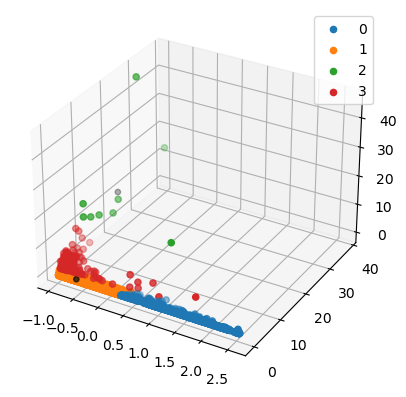

In [ ]:
# DFM clustering graph
centroids = kmeans.cluster_centers_
u_labels = np.unique(cluster_labels)
ax = plt.axes(projection='3d')

 
#plotting the results:
ax.scatter(centroids[:,0] , centroids[:,1] , centroids[:,2], s = 15, color = 'black')

for i in u_labels:
    ax.scatter(rfmvd_scaled[rfmvd.Labels == i]['Recency'] , rfmvd_scaled[rfmvd.Labels == i]['Frequency'] , rfmvd_scaled[rfmvd.Labels == i]['Monetary'], label = i)
ax.legend()
plt.show()

In [ ]:
# DFM
vars = ['Duration', 'Monetary', 'Frequency']
kmeans = KMeans(n_clusters=n, max_iter=300, random_state=1)
kmeans.fit(rfmvd_scaled[vars])

c:\Users\pc\miniconda3\envs\env1\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=1)

In [ ]:
cluster_labels = kmeans.labels_
rfmvd['Labels'] = cluster_labels
silhouette_avg = silhouette_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the silhouette score is {1}".format(n, silhouette_avg))

cal_avg = calinski_harabasz_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the calinski score is {1}".format(n, cal_avg))

db_index = davies_bouldin_score(rfmvd_scaled[vars], cluster_labels)
print("For n_clusters={0}, the davis_bouldin score is {1}".format(n, db_index))

For n_clusters=4, the silhouette score is 0.7394756223006301
For n_clusters=4, the calinski score is 3180.744309308563
For n_clusters=4, the davis_bouldin score is 0.6472776381454666


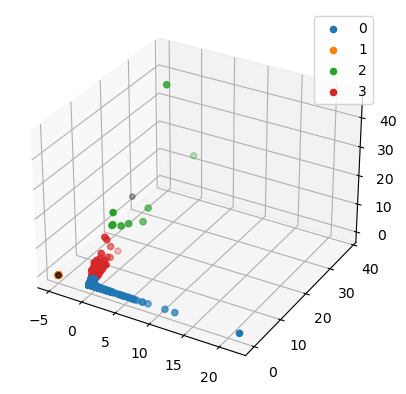

In [ ]:
# DFM clustering graph
centroids = kmeans.cluster_centers_
u_labels = np.unique(cluster_labels)
ax = plt.axes(projection='3d')

 
#plotting the results:
ax.scatter(centroids[:,0] , centroids[:,1] , centroids[:,2], s = 15, color = 'black')

for i in u_labels:
    ax.scatter(rfmvd_scaled[rfmvd.Labels == i]['Duration'] , rfmvd_scaled[rfmvd.Labels == i]['Frequency'] , rfmvd_scaled[rfmvd.Labels == i]['Monetary'], label = i)
ax.legend()
plt.show()

# Comparison (Accuracy scores)

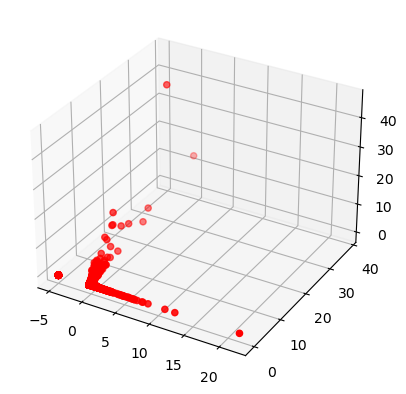

74.12275449101796

In [76]:
ax = plt.axes(projection='3d')
ax.scatter(rfmvd_scaled['Duration'], rfmvd_scaled['Frequency'], rfmvd_scaled['Monetary'], c=['red'])
plt.show()
rfmvd['Variety'].mean()